In [220]:
import os
import opendatasets as od
import pandas as pd
import seaborn as sns
import numpy as np
import math
import graphviz

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [221]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Skipping, found downloaded files in "./rossmann-store-sales" (use force=True to force download)


In [222]:
os.listdir('rossmann-store-sales')

['store.csv', 'train.csv', 'sample_submission.csv', 'test.csv']

In [223]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [224]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [225]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [226]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [227]:
split_date(merged_df)
split_date(merged_test_df)

In [228]:
merged_df[merged_df.Open == 0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

In [229]:
merged_df = merged_df[merged_df.Open == 1].copy()

In [230]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [231]:
comp_months(merged_df)
comp_months(merged_test_df)

In [232]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
326963,2014-09-26,440.0,NaN,NaN,0.0
1000352,2013-01-16,40.0,2014.0,3.0,0.0
820172,2013-06-26,32330.0,2014.0,3.0,0.0
176682,2015-02-23,400.0,2013.0,8.0,18.0
440731,2014-06-02,300.0,2000.0,7.0,167.0
845115,2013-06-04,15270.0,NaN,NaN,0.0
750520,2013-08-28,16490.0,NaN,NaN,0.0
436992,2014-06-05,1790.0,2011.0,5.0,37.0
200504,2015-02-02,850.0,2012.0,2.0,36.0
95549,2015-05-07,6970.0,2005.0,12.0,113.0


In [233]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [234]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [235]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
523582,2014-03-19,0,NaN,NaN,NaN,0.000000,0
682485,2013-10-28,1,2013.0,31.0,"Feb,May,Aug,Nov",2.983607,0
993580,2013-01-22,0,NaN,NaN,NaN,0.000000,0
306135,2014-10-18,1,2012.0,35.0,"Mar,Jun,Sept,Dec",25.606557,0
1013879,2013-01-03,1,2011.0,14.0,"Jan,Apr,Jul,Oct",21.016393,1
830127,2013-06-17,1,2009.0,45.0,"Feb,May,Aug,Nov",43.409836,0
750900,2013-08-27,0,NaN,NaN,NaN,0.000000,0
108510,2015-04-25,1,2012.0,22.0,"Feb,May,Aug,Nov",34.852459,0
114045,2015-04-20,0,NaN,NaN,NaN,0.000000,0
728108,2013-09-17,0,NaN,NaN,NaN,0.000000,0


In [236]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [237]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [238]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [239]:
test_inputs = merged_test_df[input_cols].copy()

In [240]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

In [241]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [242]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

In [243]:
max_distance = inputs.CompetitionDistance.max()

In [244]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

/tmp/ipykernel_24995/751725973.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
/tmp/ipykernel_24995/751725973.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [245]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [246]:
?OneHotEncoder

Init signature:
OneHotEncoder(
    *,
    categories='auto',
    drop=None,
    sparse_output=True,
    dtype=<class 'numpy.float64'>,
    handle_unknown='error',
    min_frequency=None,
    max_categories=None,
    feature_name_combiner='concat',
)
Docstring:     
Encode categorical features as a one-hot numeric array.

The input to this transformer should be an array-like of integers or
strings, denoting the values taken on by categorical (discrete) features.
The features are encoded using a one-hot (aka 'one-of-K' or 'dummy')
encoding scheme. This creates a binary column for each category and
returns a sparse matrix or dense array (depending on the ``sparse_output``
parameter).

By default, the encoder derives the categories based on the unique values
in each feature. Alternatively, you can also specify the `categories`
manually.

This encoding is needed for feeding categorical data to many scikit-learn
estimators, notably linear models and SVMs with the standard kernels.

Note: a o

In [247]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [248]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [249]:
?XGBRegressor

Init signature:
XGBRegressor(
    *,
    objective: Union[str, xgboost.sklearn._SklObjWProto, Callable[[Any, Any], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.
See :doc:`/python/sklearn_estimator` for more information.

Parameters
----------

    n_estimators : typing.Optional[int]
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth :  typing.Optional[int]

        Maximum tree depth for base learners.

    max_leaves : typing.Optional[int]

        Maximum number of leaves; 0 indicates no limit.

    max_bin : typing.Optional[int]

        If using histogram-based algorithm, maximum number of bins per feature

    grow_policy : typing.Optional[str]

        Tree growing policy.

        - depthwise: Favors splitting at nodes closest to the node,
        - lossguide: Favors splitting at nodes with hig

In [250]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [251]:
model.fit(X, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=20,
             n_jobs=-1, num_parallel_tree=None, ...)

In [252]:
preds = model.predict(X)

In [253]:
def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

In [254]:
rmse(preds, targets)

2397.161446377778

In [255]:
plt.rcParams['figure.figsize'] = 30,30

<Axes: >

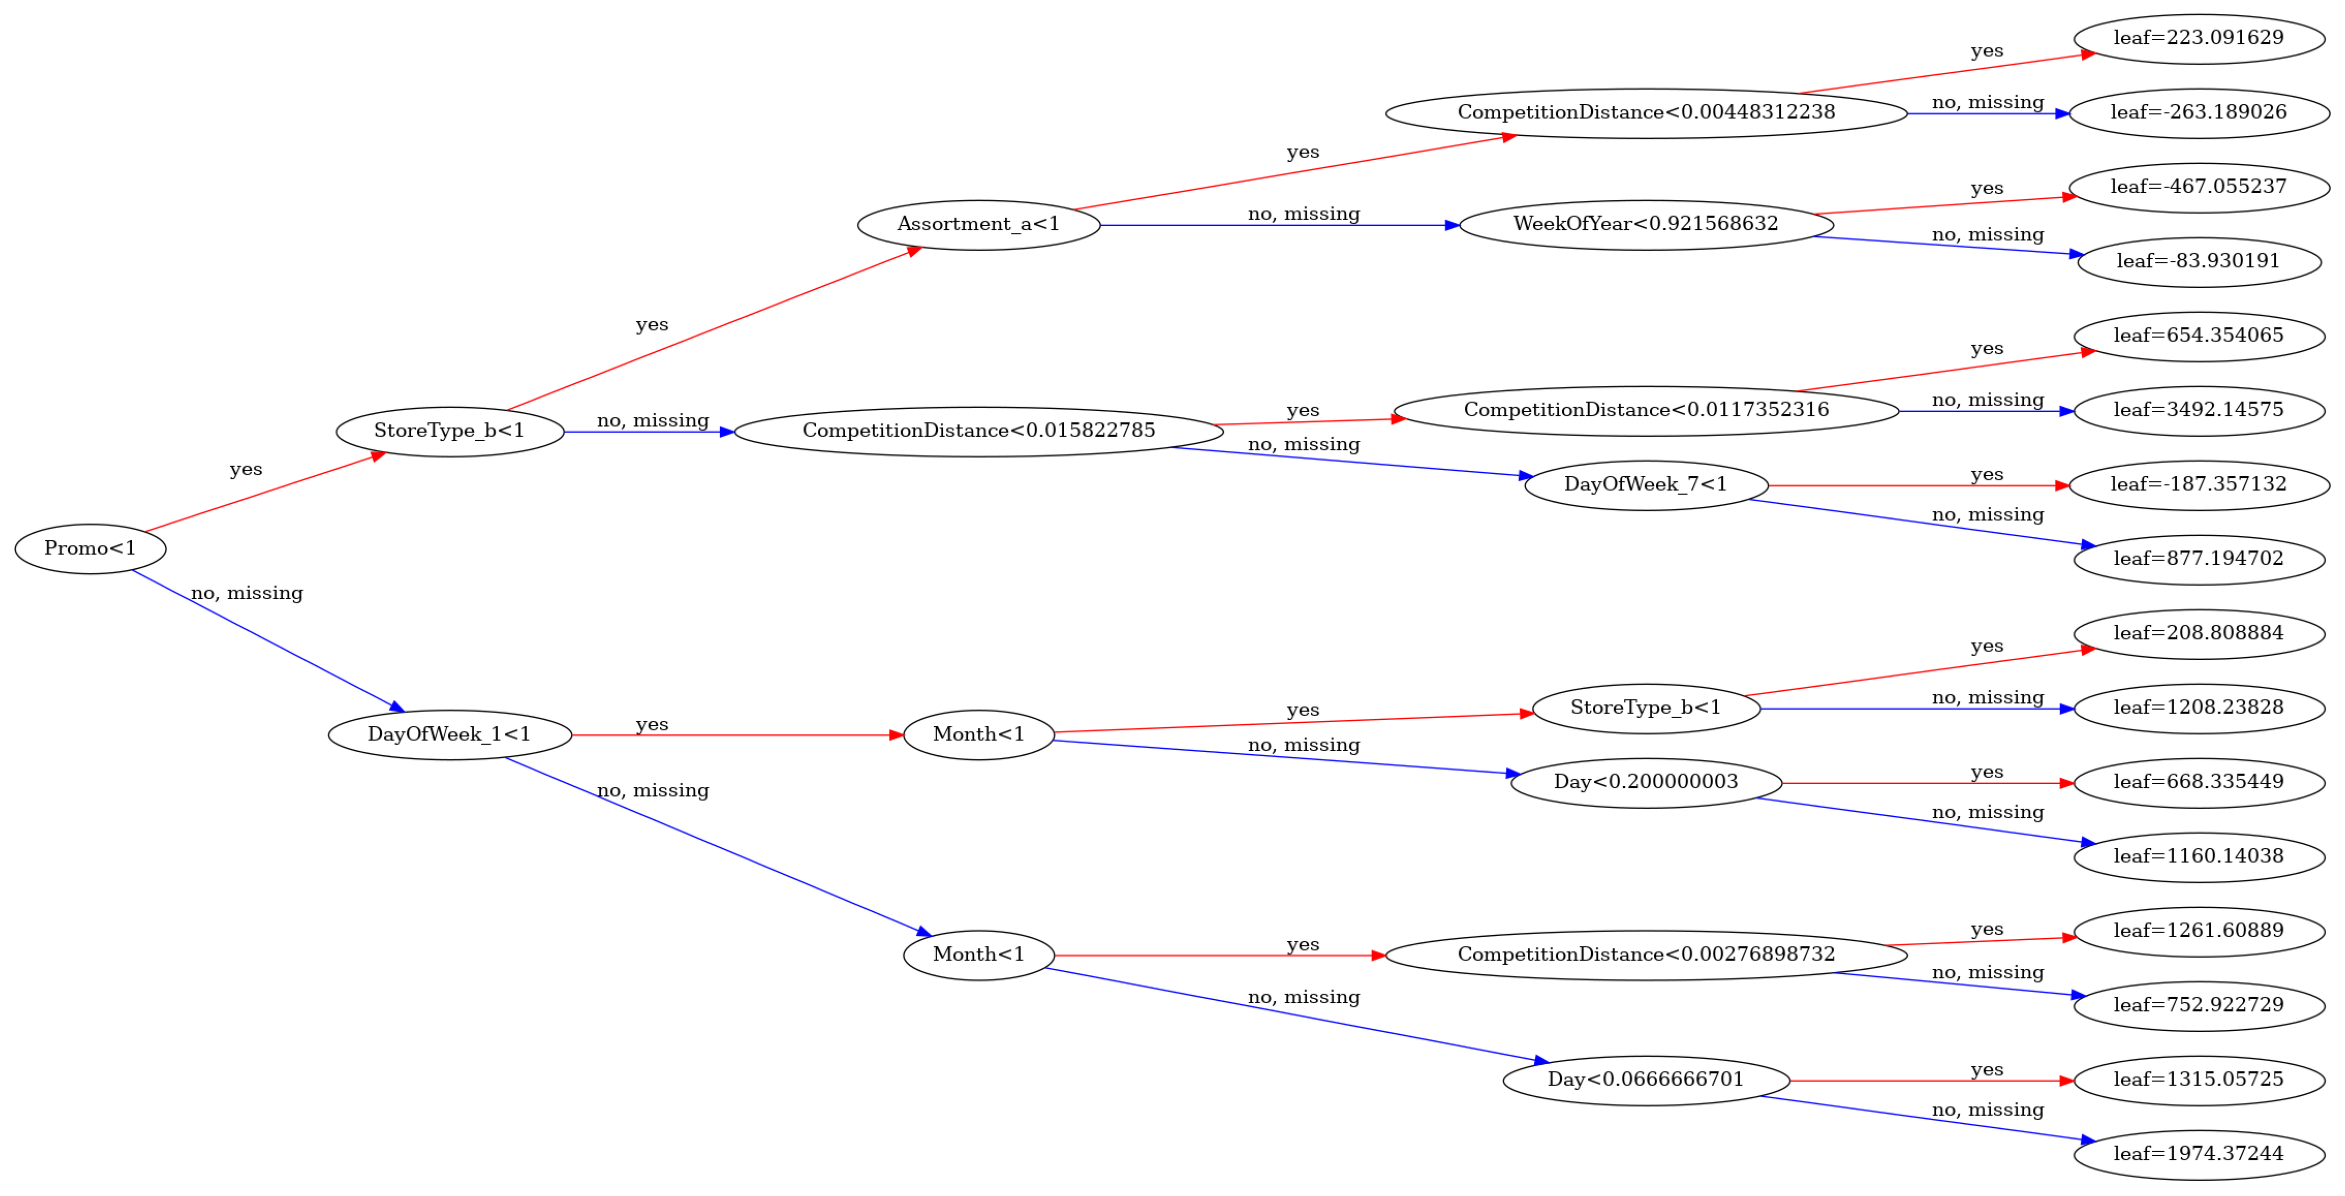

In [256]:
plot_tree(model, rankdir='LR')

/home/kurios/Documents/Machine_Learning/venv/lib/python3.10/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Axes: >

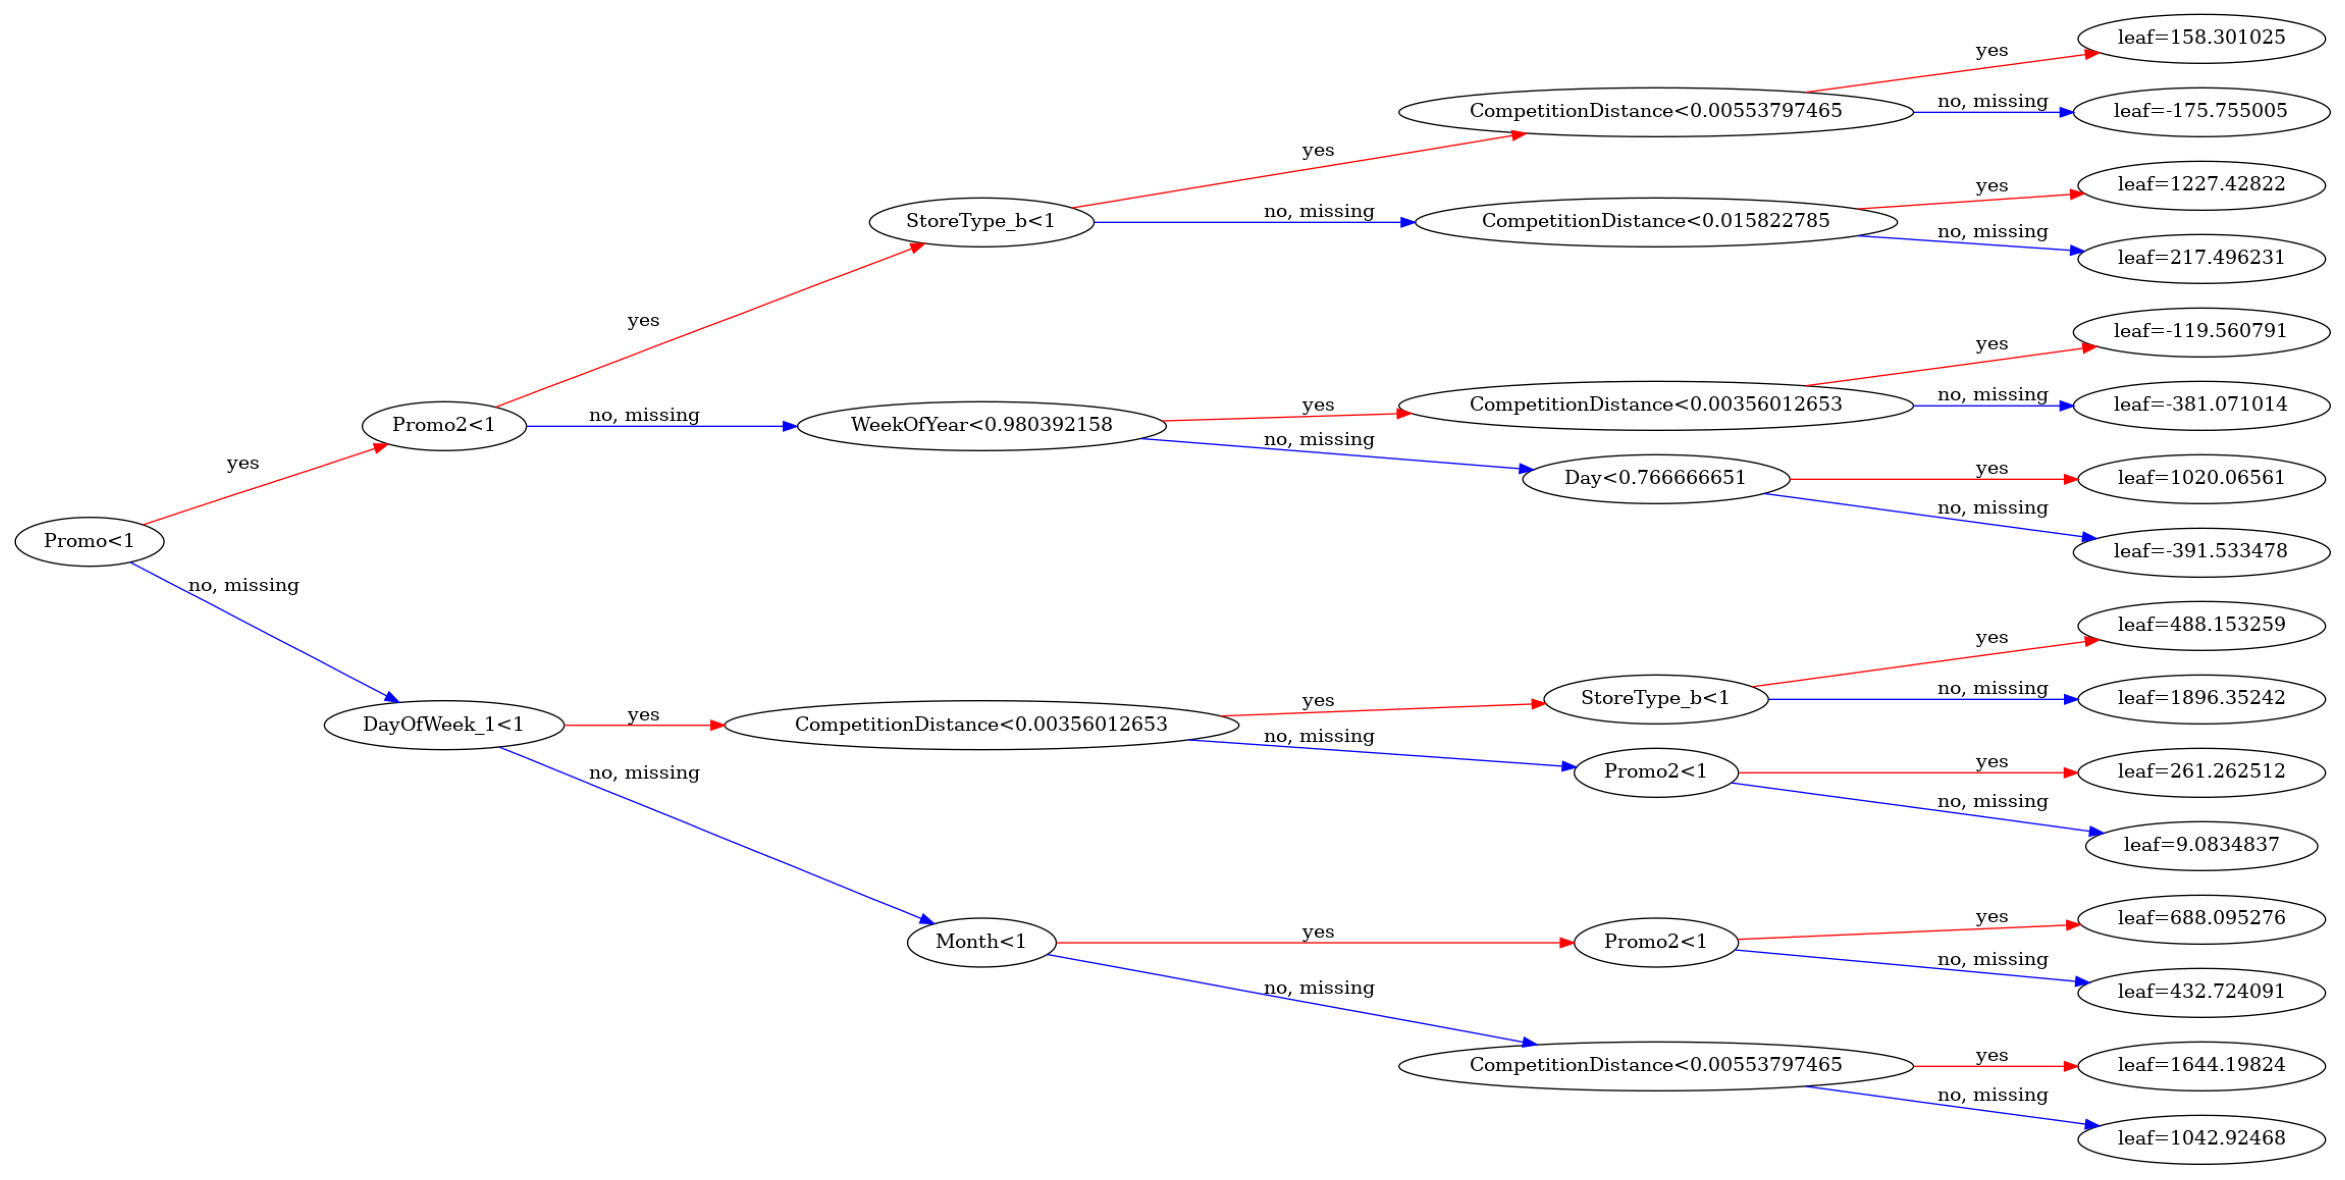

In [257]:
plot_tree(model, rankdir='LR', num_trees=1)

/home/kurios/Documents/Machine_Learning/venv/lib/python3.10/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Axes: >

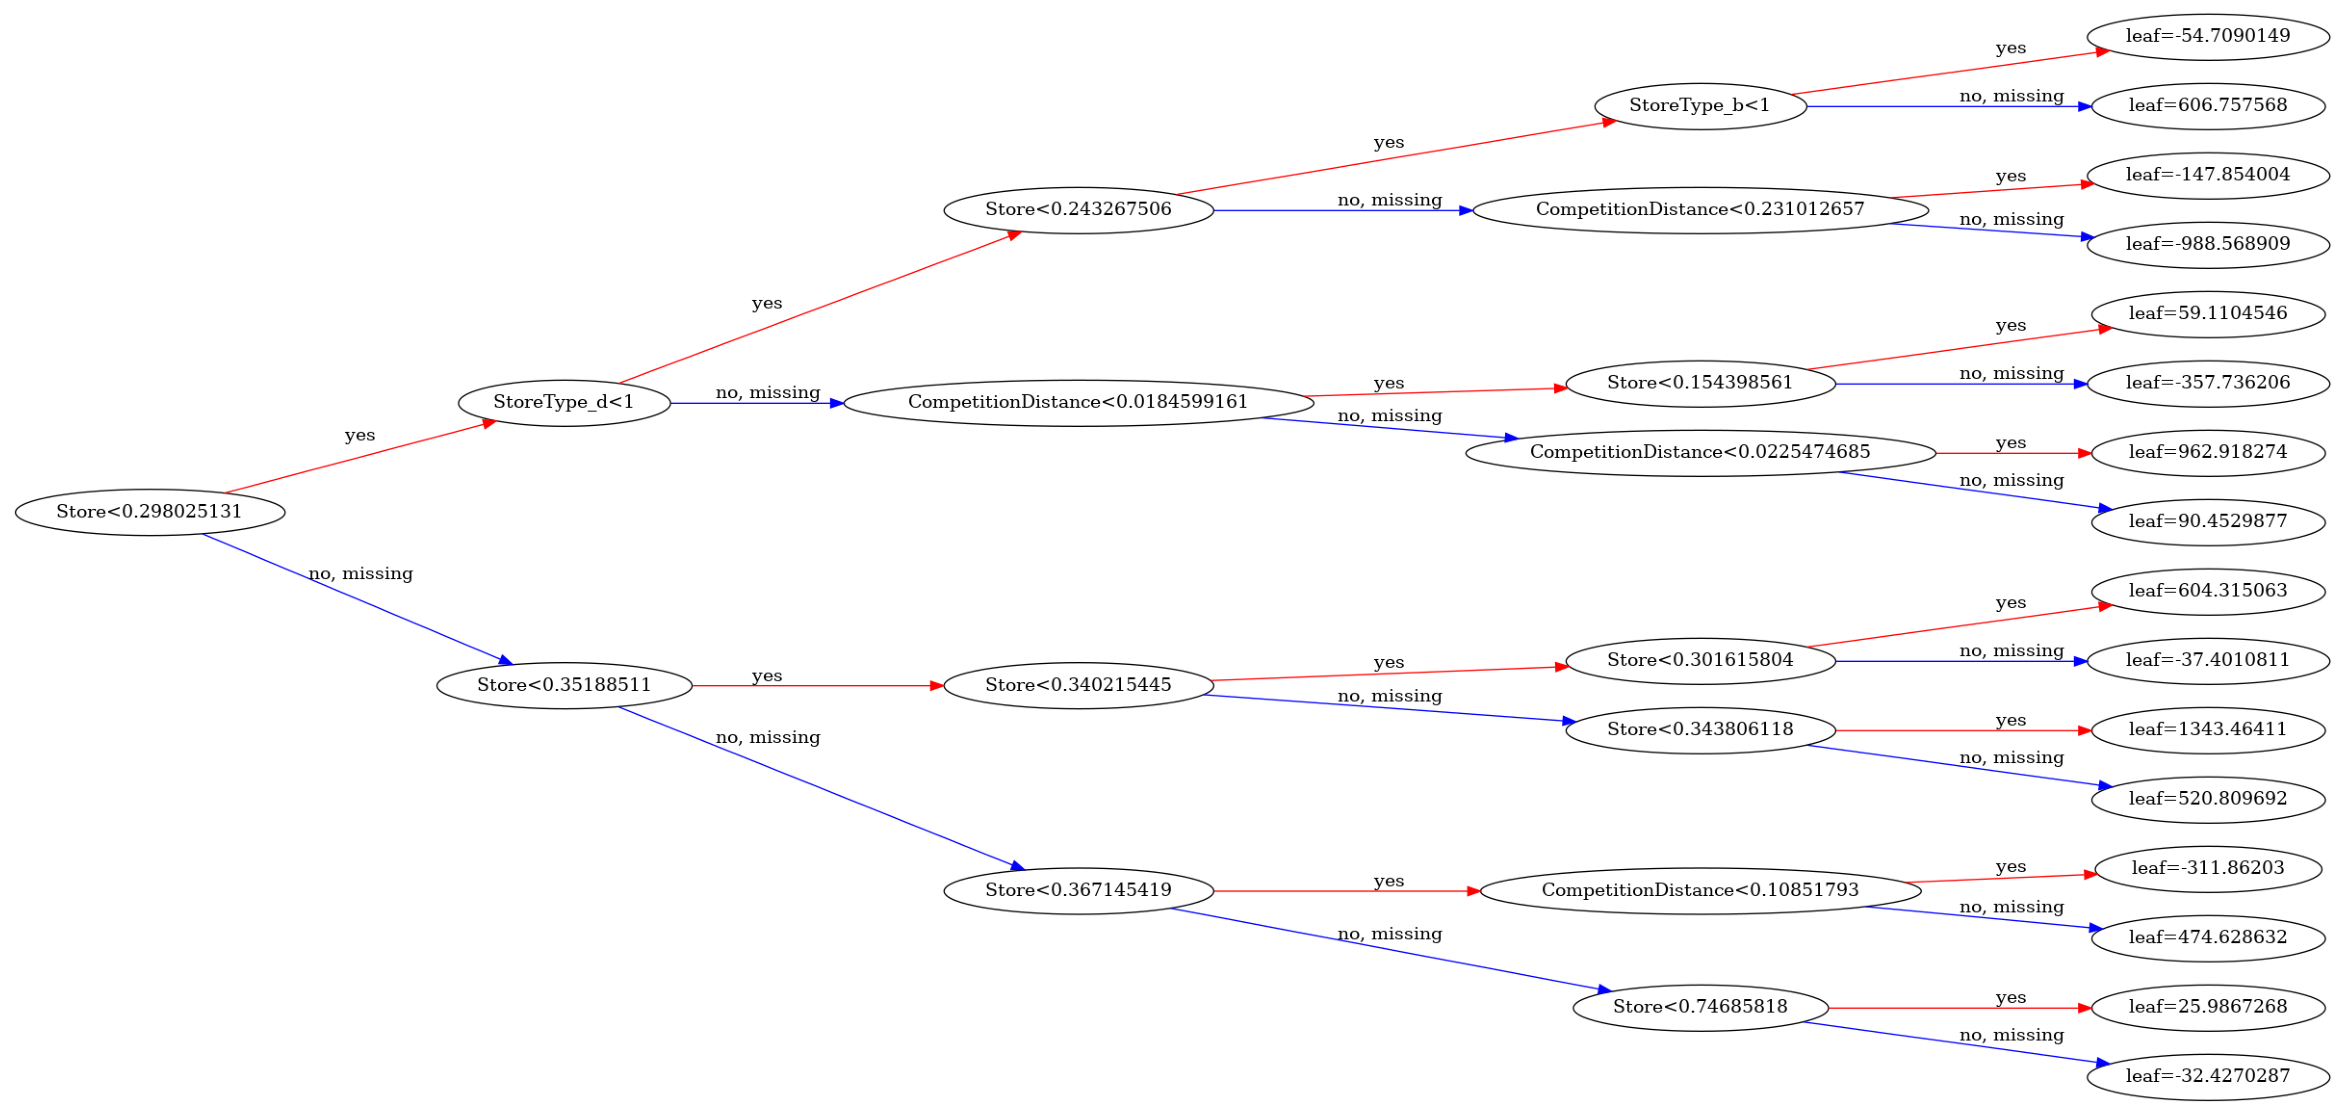

In [258]:
plot_tree(model, rankdir='LR', num_trees=19)

In [259]:
trees = model.get_booster().get_dump()

In [260]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [261]:
importance_df.head(10)

,feature,importance
1,Promo,0.334846
12,DayOfWeek_1,0.076257
24,StoreType_b,0.069301
5,Promo2,0.052821
26,StoreType_d,0.051002
9,Month,0.036114
27,Assortment_a,0.034672
11,WeekOfYear,0.034646
29,Assortment_c,0.034157
3,CompetitionDistance,0.030939


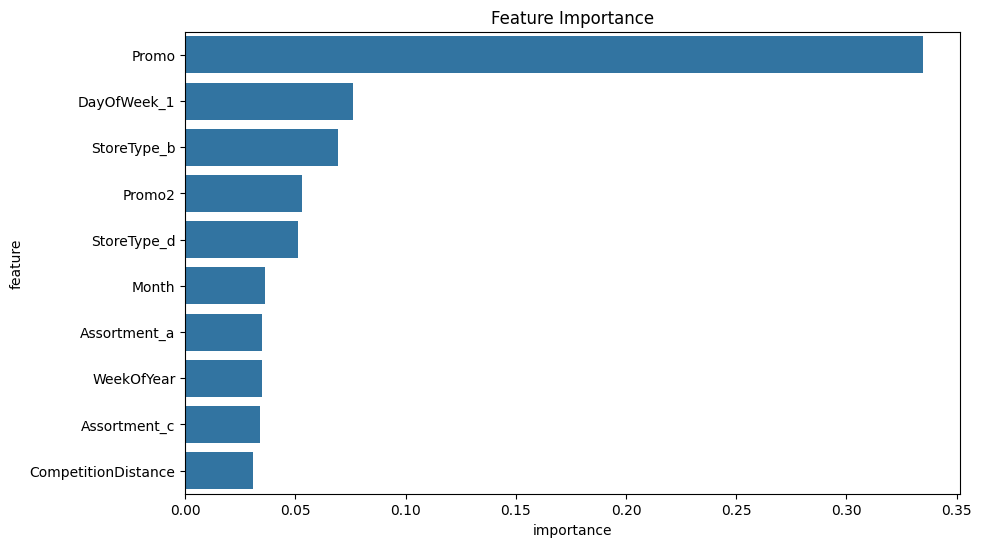

In [262]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [263]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

In [264]:
kfold = KFold(n_splits=5)

In [265]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2394.7877776537944, Validation RMSE: 2462.850381164069
Train RMSE: 2401.158158056233, Validation RMSE: 2449.841831629136
Train RMSE: 2411.892825147917, Validation RMSE: 2391.5909976415282
Train RMSE: 2344.831337218095, Validation RMSE: 2440.0443643507797
Train RMSE: 2391.1546374084633, Validation RMSE: 2460.874234901085


In [266]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [267]:
preds = predict_avg(models, X)

In [268]:
preds

array([8031.8696, 7536.164 , 8671.131 , ..., 7181.968 , 7955.146 ,
       9629.75  ], shape=(844392,), dtype=float32)

In [269]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [270]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

In [271]:
test_params(n_estimators=10)

Train RMSE: 2337.453528949827, Validation RMSE: 2354.467137167134


In [272]:
test_params(n_estimators=30)

Train RMSE: 1863.0559572916752, Validation RMSE: 1879.7386786465825


In [273]:
test_params(n_estimators=100)

Train RMSE: 1161.262405746436, Validation RMSE: 1177.8312697496192


In [274]:
test_params(n_estimators=240)

Train RMSE: 899.4291939891656, Validation RMSE: 922.8866737037653


In [275]:
test_params(max_depth=2)

Train RMSE: 2383.7221943842364, Validation RMSE: 2401.0172844025924


In [276]:
test_params(max_depth=5)

Train RMSE: 1411.6901660775286, Validation RMSE: 1420.9041575701015


In [277]:
test_params(max_depth=10)

Train RMSE: 663.2752775055014, Validation RMSE: 768.484303678351


In [278]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 2786.799328979394, Validation RMSE: 2803.681864976838


In [279]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2189.149149783998, Validation RMSE: 2206.8455994926335


In [280]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 1584.855829405312, Validation RMSE: 1600.5501397956891


In [281]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 1123.9663584823168, Validation RMSE: 1141.2022169624452


In [282]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 1184.343172395569, Validation RMSE: 1206.2523575106495


In [283]:
test_params(booster='gblinear')

Train RMSE: 2724.0759901294973, Validation RMSE: 2745.0285062272123


In [284]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [285]:
model.fit(X, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [286]:
test_preds = model.predict(X_test)

In [287]:
submission_df['Sales']  = test_preds

In [288]:
test_df.Open.isna().sum()

np.int64(11)

In [289]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)
submission_df

,Id,Sales
0,1,4147.634277
1,2,7986.980957
2,3,8843.880859
3,4,6923.383301
4,5,7496.728027
...,...,...
41083,41084,2566.565430
41084,41085,7192.880859
41085,41086,7318.949707
41086,41087,24592.515625
